In [1]:
# Block 0: Install (optional) and imports
# Run this cell first in Colab. Remove installs if running locally and already installed.

import os, sys, subprocess, warnings
warnings.filterwarnings("ignore")

# Optional: install heavy libs in Colab (comment out if you don't want installs)
def pip_install(pkgs):
    for p in pkgs:
        try:
            __import__(p.split("==")[0])
        except Exception:
            print("Installing", p)
            subprocess.check_call([sys.executable, "-m", "pip", "install", p])

# Uncomment or edit the list below if you need to install.
pip_install(["pandas", "scikit-learn", "matplotlib", "shap", "lime", "tensorflow==2.13.0"])

# Imports
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.inspection import permutation_importance, PartialDependenceDisplay
import joblib
os.makedirs("/content/stroke_model_results", exist_ok=True)
print("Output folder: /content/stroke_model_results")
# Check TensorFlow, SHAP, LIME availability
try:
    import tensorflow as tf
    print("TensorFlow:", tf.__version__)
    TF_AVAILABLE = True
except Exception:
    print("TensorFlow NOT available; DL fallback to sklearn MLPClassifier will be used.")
    TF_AVAILABLE = False

try:
    import shap
    SHAP_AVAILABLE = True
    print("shap available")
except Exception:
    SHAP_AVAILABLE = False
    print("shap NOT available")

try:
    from lime import lime_tabular
    LIME_AVAILABLE = True
    print("lime available")
except Exception:
    LIME_AVAILABLE = False
    print("lime NOT available")


Installing scikit-learn
Installing lime
Output folder: /content/stroke_model_results
TensorFlow: 2.19.0
shap available
lime available


In [3]:
# Block 1: Load dataset & quick EDA
DATA_PATH = "/content/brain_stroke.csv"
df = pd.read_csv(DATA_PATH)
print("Loaded:", DATA_PATH, "shape:", df.shape)
display(df.head())
print("\nColumns:", df.columns.tolist())

# Auto-detect target (prefer column named 'stroke' case-insensitive)
target_candidates = [c for c in df.columns if c.lower() == "stroke" or "stroke" in c.lower()]
target = target_candidates[0] if target_candidates else df.columns[-1]
print("Using target column:", target)

# Drop obvious identifier columns if present
for idc in ['id','Id','ID','patient_id']:
    if idc in df.columns:
        print("Dropping identifier column:", idc)
        df.drop(columns=[idc], inplace=True)


Loaded: /content/brain_stroke.csv shape: (4981, 11)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1



Columns: ['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status', 'stroke']
Using target column: stroke


In [5]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

# Separate X, y
X = df.drop(columns=[target])
y = df[target].copy()

# Encode target to 0/1 if object
if y.dtype == object or y.dtype.name == 'category':
    le_target = LabelEncoder()
    y = le_target.fit_transform(y)
    print("Target classes:", le_target.classes_)

# Identify numeric vs categorical features
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in numeric_cols]
print("Numeric cols:", numeric_cols)
print("Categorical cols:", cat_cols)

# Build transformers
numeric_transformer = Pipeline([("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())])
categorical_transformer = Pipeline([("imputer", SimpleImputer(strategy="most_frequent")), ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))])

preprocessor = ColumnTransformer(transformers=[("num", numeric_transformer, numeric_cols), ("cat", categorical_transformer, cat_cols)], remainder="drop")

# Fit-transform
X_processed = preprocessor.fit_transform(X)

# Compose feature names
feature_names = []
if numeric_cols:
    feature_names.extend(numeric_cols)
if cat_cols:
    ohe = preprocessor.named_transformers_['cat'].named_steps['onehot']
    feature_names.extend(ohe.get_feature_names_out(cat_cols).tolist())

X_processed = pd.DataFrame(X_processed, columns=feature_names)
print("Processed X shape:", X_processed.shape)
display(X_processed.head())

# Split (80/20)
stratify = y if len(np.unique(y))==2 else None
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42, stratify=stratify)
print("Train:", X_train.shape, "Test:", X_test.shape)

# Save processed objects
X_processed.head(5).to_csv("/content/stroke_model_results/processed_X_head.csv", index=False)
pd.Series(feature_names).to_csv("/content/stroke_model_results/feature_names.csv", index=False)

Numeric cols: ['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi']
Categorical cols: ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
Processed X shape: (4981, 19)


,age,hypertension,heart_disease,avg_glucose_level,bmi,gender_Female,gender_Male,ever_married_No,ever_married_Yes,work_type_Govt_job,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Rural,Residence_type_Urban,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,1.040584,-0.326186,4.136753,2.723411,1.193238,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,1.614270,-0.326186,4.136753,-0.000523,0.589390,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,0.246250,-0.326186,-0.241735,1.448529,0.869222,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
3,1.570141,3.065738,-0.241735,1.512650,-0.662492,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
4,1.658400,-0.326186,-0.241735,1.780895,0.073909,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0


Train: (3984, 19) Test: (997, 19)



---- Training LogisticRegression ----
LogisticRegression -> Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, ROC-AUC: 0.8459345300950369

---- Training KNN ----
KNN -> Acc: 0.9448, Prec: 0.1429, Rec: 0.0200, F1: 0.0351, ROC-AUC: 0.6364519535374868

---- Training SVC ----
SVC -> Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, ROC-AUC: 0.6851108764519536

---- Training DecisionTree ----
DecisionTree -> Acc: 0.9007, Prec: 0.1343, Rec: 0.1800, F1: 0.1538, ROC-AUC: 0.5593769799366419

---- Training RandomForest ----
RandomForest -> Acc: 0.9488, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, ROC-AUC: 0.8132734952481521

---- Training GradientBoosting ----
GradientBoosting -> Acc: 0.9488, Prec: 0.3333, Rec: 0.0200, F1: 0.0377, ROC-AUC: 0.844857444561774

---- Training GaussianNB ----
GaussianNB -> Acc: 0.7974, Prec: 0.1381, Rec: 0.5800, F1: 0.2231, ROC-AUC: 0.7828511087645196

---- Training AdaBoost ----
AdaBoost -> Acc: 0.9498, Prec: 0.0000, Rec: 0.0000, F1: 0.0000, ROC-AUC: 0.84257655755015

,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,GaussianNB,0.797392,0.138095,0.58,0.223077,0.782851
1,DecisionTree,0.900702,0.134328,0.18,0.153846,0.559377
2,GradientBoosting,0.948847,0.333333,0.02,0.037736,0.844857
3,KNN,0.944835,0.142857,0.02,0.035088,0.636452
4,SVC,0.949850,0.000000,0.00,0.000000,0.685111
5,LogisticRegression,0.949850,0.000000,0.00,0.000000,0.845935
6,RandomForest,0.948847,0.000000,0.00,0.000000,0.813273
7,AdaBoost,0.949850,0.000000,0.00,0.000000,0.842577


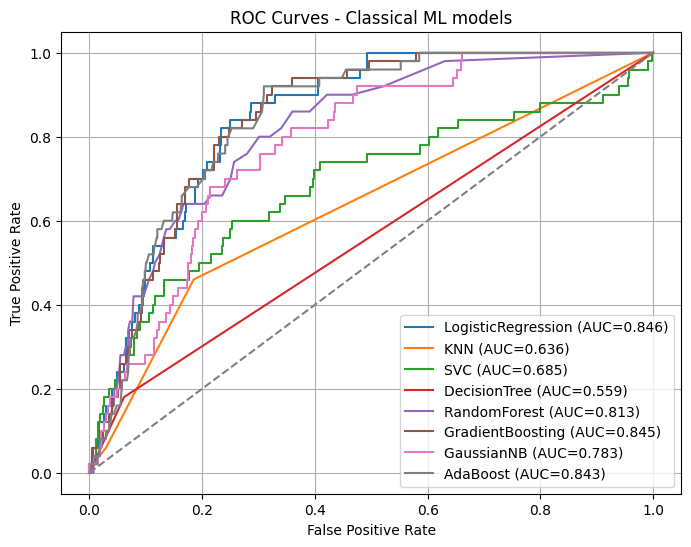

In [6]:
# Block 3: Train 8 classical ML models and evaluate
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB

models = {
    "LogisticRegression": LogisticRegression(max_iter=2000, random_state=42),
    "KNN": KNeighborsClassifier(),
    "SVC": SVC(probability=True, random_state=42),
    "DecisionTree": DecisionTreeClassifier(random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "GaussianNB": GaussianNB(),
    "AdaBoost": AdaBoostClassifier(n_estimators=200, random_state=42)
}

ml_results = []
trained_models = {}
for name, mdl in models.items():
    print(f"\n---- Training {name} ----")
    mdl.fit(X_train, y_train)
    trained_models[name] = mdl
    y_pred = mdl.predict(X_test)
    # probability/score for ROC-AUC (binary only)
    y_score = None
    if hasattr(mdl, "predict_proba"):
        p = mdl.predict_proba(X_test)
        if p.shape[1]==2:
            y_score = p[:,1]
    elif hasattr(mdl, "decision_function"):
        try:
            y_score = mdl.decision_function(X_test)
        except Exception:
            y_score = None

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    roc_auc = roc_auc_score(y_test, y_score) if (y_score is not None and len(np.unique(y_test))==2) else np.nan

    print(f"{name} -> Acc: {acc:.4f}, Prec: {prec:.4f}, Rec: {rec:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc if not np.isnan(roc_auc) else 'N/A'}")
    ml_results.append({"Model": name, "Accuracy": acc, "Precision": prec, "Recall": rec, "F1": f1, "ROC-AUC": roc_auc})

# Save results table
ml_results_df = pd.DataFrame(ml_results).sort_values(by="F1", ascending=False).reset_index(drop=True)
ml_results_df.to_csv("/content/stroke_model_results/ml_results.csv", index=False)
print("\nSaved: /content/stroke_model_results/ml_results.csv")
display(ml_results_df)

# ROC plot (models that provide scores)
plt.figure(figsize=(8,6))
for name, mdl in trained_models.items():
    try:
        if hasattr(mdl, "predict_proba"):
            score = mdl.predict_proba(X_test)[:,1]
        elif hasattr(mdl, "decision_function"):
            score = mdl.decision_function(X_test)
        else:
            continue
        if len(np.unique(y_test))==2:
            fpr, tpr, _ = roc_curve(y_test, score)
            plt.plot(fpr, tpr, label=f"{name} (AUC={auc(fpr,tpr):.3f})")
    except Exception:
        continue
plt.plot([0,1],[0,1],"--", color="gray")
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves - Classical ML models")
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("/content/stroke_model_results/roc_classical_ml.png", bbox_inches="tight")
plt.show()



Training Keras_MLP_small ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras_MLP_small -> Acc: 0.9498, F1: 0.0000


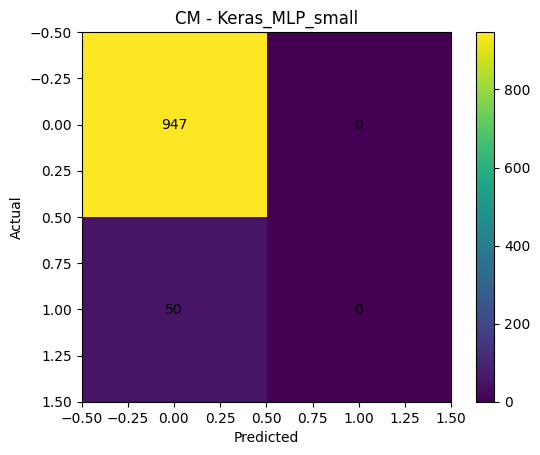


Training Keras_MLP_dropout ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras_MLP_dropout -> Acc: 0.9498, F1: 0.0000


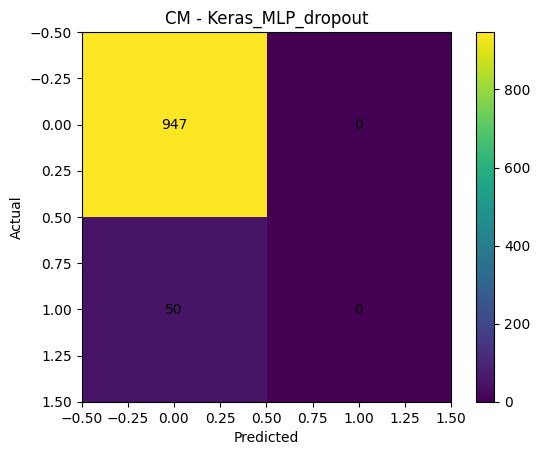


Training Keras_MLP_batchnorm ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Keras_MLP_batchnorm -> Acc: 0.9488, F1: 0.1053


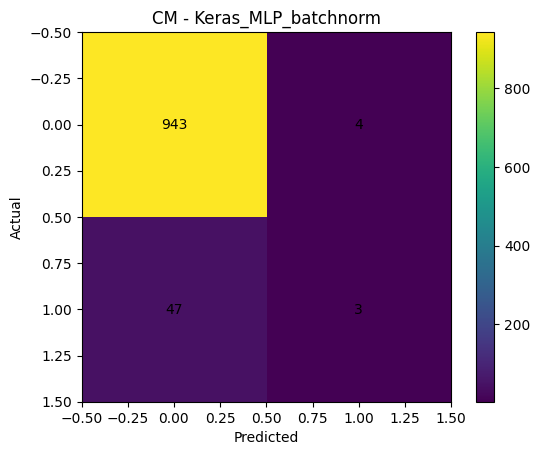


Training Keras_MLP_deep ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras_MLP_deep -> Acc: 0.9498, F1: 0.0000


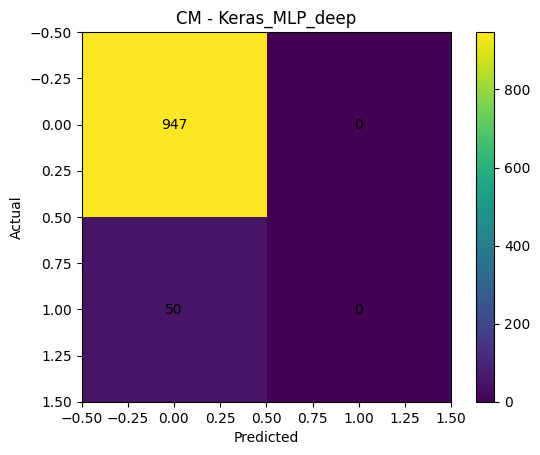


Training Keras_MLP_shallow ...
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Keras_MLP_shallow -> Acc: 0.9498, F1: 0.0000


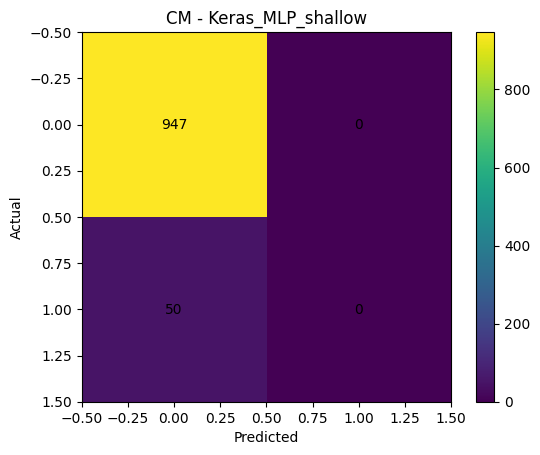

,Model,Accuracy,F1
0,Keras_MLP_small,0.949850,0.000000
1,Keras_MLP_dropout,0.949850,0.000000
2,Keras_MLP_batchnorm,0.948847,0.105263
3,Keras_MLP_deep,0.949850,0.000000
4,Keras_MLP_shallow,0.949850,0.000000


In [8]:
# Block 4A: Deep models using TensorFlow/Keras (run only if TF available)
if not TF_AVAILABLE:
    print("TensorFlow not available — skip this block.")
else:
    from tensorflow.keras import layers, models, callbacks

    # scale features for NN
    scaler_nn = StandardScaler().fit(X_train)
    X_train_nn = scaler_nn.transform(X_train)
    X_test_nn = scaler_nn.transform(X_test)

    def build_mlp(input_dim, units=[64,32], dropout=0.0, batchnorm=False):
        model = models.Sequential()
        model.add(layers.Input(shape=(input_dim,)))
        for u in units:
            model.add(layers.Dense(u, activation='relu'))
            if batchnorm:
                model.add(layers.BatchNormalization())
            if dropout>0:
                model.add(layers.Dropout(dropout))
        model.add(layers.Dense(1, activation='sigmoid'))
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        return model

    dl_specs = {
        "Keras_MLP_small": {"units":[64,32], "dropout":0.0, "batchnorm":False},
        "Keras_MLP_dropout": {"units":[128,64], "dropout":0.3, "batchnorm":False},
        "Keras_MLP_batchnorm": {"units":[128,64], "dropout":0.0, "batchnorm":True},
        "Keras_MLP_deep": {"units":[256,128,64], "dropout":0.2, "batchnorm":False},
        "Keras_MLP_shallow": {"units":[32], "dropout":0.0, "batchnorm":False}
    }

    dl_results = []
    for name, spec in dl_specs.items():
        print(f"\nTraining {name} ...")
        model = build_mlp(input_dim=X_train_nn.shape[1], units=spec["units"], dropout=spec["dropout"], batchnorm=spec["batchnorm"])
        es = callbacks.EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=0)
        history = model.fit(X_train_nn, y_train, validation_split=0.15, epochs=80, batch_size=32, callbacks=[es], verbose=0)
        y_prob = model.predict(X_test_nn).ravel()
        y_pred = (y_prob >= 0.5).astype(int)
        acc = accuracy_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred, zero_division=0)
        cm = confusion_matrix(y_test, y_pred)
        print(f"{name} -> Acc: {acc:.4f}, F1: {f1:.4f}")
        dl_results.append({"Model": name, "Accuracy": acc, "F1": f1})
        # save model, cm, history
        model.save(f"/content/stroke_model_results/{name}_keras_model.keras") # FIX: Added .keras extension
        pd.DataFrame(history.history).to_csv(f"/content/stroke_model_results/{name}_history.csv", index=False)
        # plot + save confusion matrix
        plt.figure(); plt.imshow(cm, interpolation='nearest'); plt.title(f"CM - {name}")
        for (i,j), val in np.ndenumerate(cm): plt.text(j,i,int(val),ha='center',va='center')
        plt.colorbar(); plt.xlabel("Predicted"); plt.ylabel("Actual")
        plt.savefig(f"/content/stroke_model_results/cm_{name}.png", bbox_inches="tight"); plt.show()

    pd.DataFrame(dl_results).to_csv("/content/stroke_model_results/dl_results_keras.csv", index=False)
    display(pd.DataFrame(dl_results))


Top features for RandomForest:


,feature,importance
3,avg_glucose_level,0.262099
4,bmi,0.232333
0,age,0.231766
1,hypertension,0.030352
2,heart_disease,0.023382
10,work_type_Private,0.020955
17,smoking_status_never smoked,0.020761
14,Residence_type_Urban,0.020104
13,Residence_type_Rural,0.020100
16,smoking_status_formerly smoked,0.019043


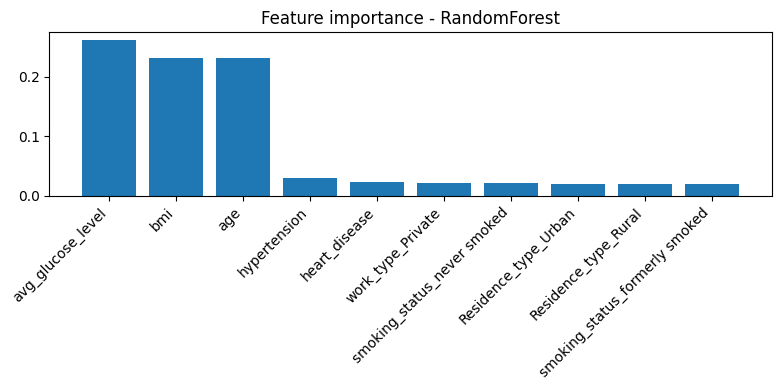


Top features for GradientBoosting:


,feature,importance
3,avg_glucose_level,0.365293
0,age,0.327801
4,bmi,0.144270
2,heart_disease,0.034168
17,smoking_status_never smoked,0.029731
1,hypertension,0.022548
9,work_type_Govt_job,0.014156
15,smoking_status_Unknown,0.010626
8,ever_married_Yes,0.009536
14,Residence_type_Urban,0.008875


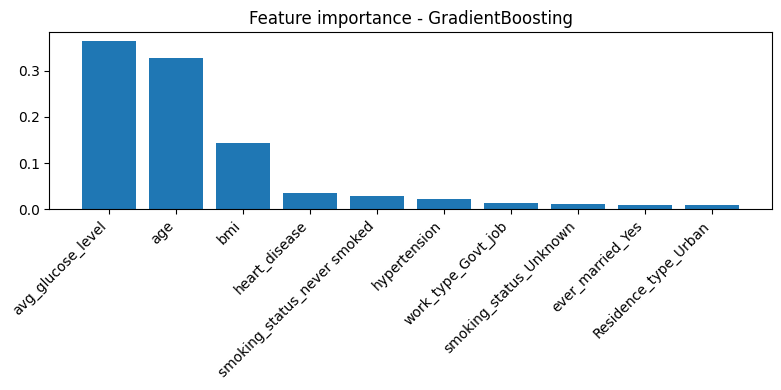

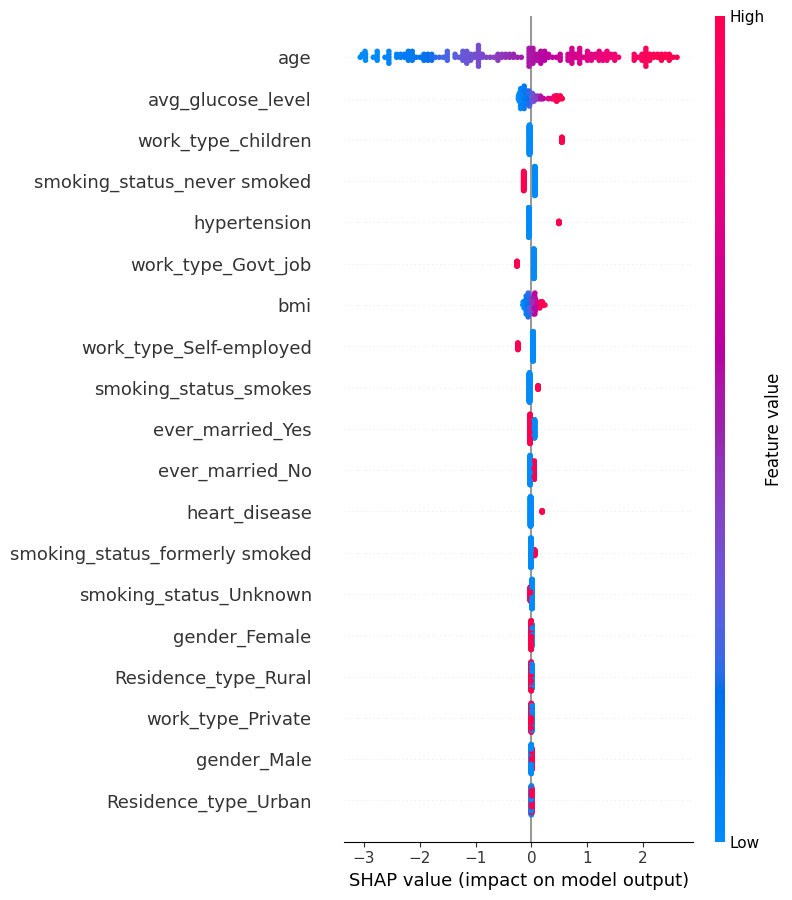

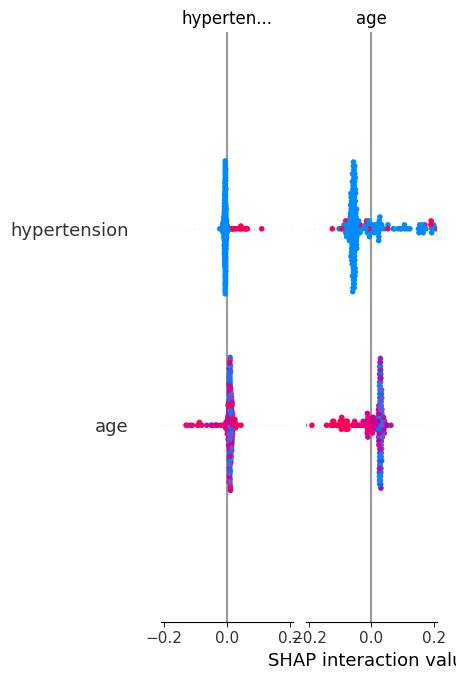


LIME explanation for test instance 0:
[('hypertension <= -0.33', -0.061173523910432875),
 ('-0.77 < age <= 0.07', -0.04427244699628597),
 ('heart_disease <= -0.24', -0.03308309009901903),
 ('-0.63 < avg_glucose_level <= -0.31', -0.013458221190552047),
 ('smoking_status_smokes <= 0.00', -0.008269605021408792),
 ('smoking_status_formerly smoked > 0.00', 0.007696913676478178)]

LIME explanation for test instance 1:
[('hypertension > -0.33', 0.06412245444745977),
 ('heart_disease <= -0.24', -0.03129748359733103),
 ('-0.31 < avg_glucose_level <= 0.19', -0.007858959693647654),
 ('0.07 < age <= 0.78', -0.0075858477605065975),
 ('-0.68 < bmi <= -0.04', -0.007136636073721229),
 ('ever_married_No <= 0.00', -0.005422084798029004)]

LIME explanation for test instance 2:
[('hypertension <= -0.33', -0.06034238835991498),
 ('age <= -0.77', -0.04875891743537954),
 ('heart_disease <= -0.24', -0.033736117986061194),
 ('smoking_status_never smoked <= 0.00', 0.008282517407860275),
 ('work_type_children >

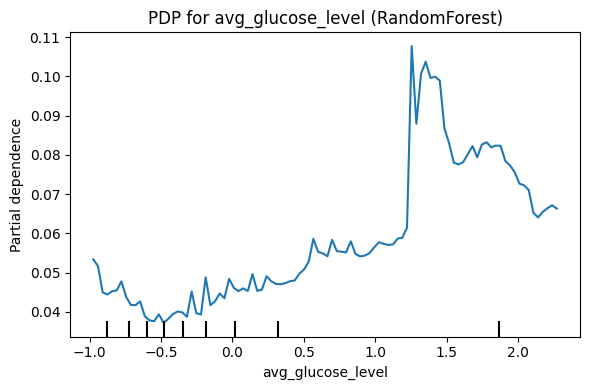

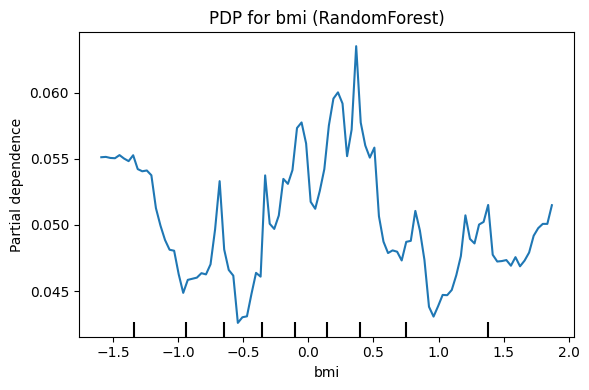

In [9]:
# Block 5: Explainable AI (XAI) - Feature importance, SHAP, LIME, PDP/ICE
import numpy as np
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.neighbors import NearestNeighbors

# 1) Feature importance from tree-based models (RandomForest, GradientBoosting)
tree_names = [n for n in ["RandomForest","GradientBoosting"] if n in trained_models]
for tn in tree_names:
    mdl = trained_models[tn]
    try:
        imp = mdl.feature_importances_
        fi_df = pd.DataFrame({"feature": feature_names, "importance": imp}).sort_values("importance", ascending=False)
        fi_df.to_csv(f"/content/stroke_model_results/feature_importance_{tn}.csv", index=False)
        print(f"\nTop features for {tn}:"); display(fi_df.head(10))
        # plot
        plt.figure(figsize=(8,4)); plt.bar(fi_df['feature'].head(10), fi_df['importance'].head(10)); plt.xticks(rotation=45, ha='right')
        plt.title(f"Feature importance - {tn}"); plt.tight_layout(); plt.savefig(f"/content/stroke_model_results/fi_{tn}.png"); plt.show()
    except Exception as e:
        print(f"Cannot compute feature importance for {tn}:", e)

# 2) SHAP (attempt), fallback to permutation importance if SHAP unavailable
if SHAP_AVAILABLE:
    # sample for speed
    X_train_sample = X_train.sample(n=min(200,len(X_train)), random_state=42)
    X_test_sample = X_test.sample(n=min(200,len(X_test)), random_state=42)
    # Logistic Regression (LinearExplainer)
    if "LogisticRegression" in trained_models:
        try:
            explainer = shap.LinearExplainer(trained_models["LogisticRegression"], X_train_sample, feature_perturbation="interventional")
            shap_vals = explainer.shap_values(X_test_sample)
            shap.summary_plot(shap_vals, X_test_sample, feature_names=feature_names, show=True)
        except Exception as e:
            print("SHAP LinearExplainer failed:", e)
    # RandomForest (TreeExplainer)
    if "RandomForest" in trained_models:
        try:
            explainer = shap.TreeExplainer(trained_models["RandomForest"])
            shap_vals = explainer.shap_values(X_test_sample)
            if isinstance(shap_vals, list):
                shap_vals = shap_vals[1]
            shap.summary_plot(shap_vals, X_test_sample, feature_names=feature_names, show=True)
        except Exception as e:
            print("SHAP TreeExplainer failed:", e)
    # DL model SHAP attempt (may be slow)
    # If Keras model exists (saved earlier), you'd need to load and use KernelExplainer/DeepExplainer appropriately.
else:
    print("SHAP not available -> using permutation importance fallback for LR and RF")
    for name in ["LogisticRegression","RandomForest"]:
        if name in trained_models:
            try:
                r = permutation_importance(trained_models[name], X_test, y_test, n_repeats=15, random_state=42, n_jobs=1)
                perm_df = pd.DataFrame({"feature": feature_names, "importance_mean": r.importances_mean, "importance_std": r.importances_std}).sort_values("importance_mean", ascending=False)
                perm_df.to_csv(f"/content/stroke_model_results/permutation_importance_{name}.csv", index=False)
                print(f"\nPermutation importance for {name}:"); display(perm_df.head(10))
            except Exception as e:
                print("Permutation importance failed for", name, e)

# 3) LIME local explanations (attempt), else local surrogate decision tree
if LIME_AVAILABLE:
    explainer = lime_tabular.LimeTabularExplainer(training_data=np.array(X_train),
                                                  feature_names=feature_names,
                                                  class_names=[str(c) for c in np.unique(y_train)],
                                                  mode='classification')
    for i in range(min(3, len(X_test))):
        exp = explainer.explain_instance(X_test.iloc[i].values, trained_models["RandomForest"].predict_proba, num_features=6)
        print(f"\nLIME explanation for test instance {i}:"); pprint(exp.as_list())
        with open(f"/content/stroke_model_results/lime_instance_{i}.txt", "w") as f:
            f.write(str(exp.as_list()))
else:
    print("LIME not available -> using local surrogate decision trees for 3 instances.")
    for i in range(min(3, len(X_test))):
        xi = X_test.iloc[i:i+1]
        nbrs = NearestNeighbors(n_neighbors=min(200, len(X_train))).fit(X_train)
        _, idxs = nbrs.kneighbors(xi)
        X_nb = X_train.iloc[idxs[0]]
        y_nb = trained_models["RandomForest"].predict(X_nb)
        dt = DecisionTreeClassifier(max_depth=3, random_state=42).fit(X_nb, y_nb)
        txt = export_text(dt, feature_names=feature_names)
        print(f"\nLocal surrogate for test instance {i}:\n", txt)
        with open(f"/content/stroke_model_results/local_surrogate_instance_{i}.txt", "w") as f:
            f.write(txt)

# 4) PDP & ICE for top features (pick top 2 from RandomForest importance or first 2 features)
if "RandomForest" in trained_models:
    try:
        rf_imp = trained_models["RandomForest"].feature_importances_
        rf_df = pd.DataFrame({"feature": feature_names, "importance": rf_imp}).sort_values("importance", ascending=False)
        top_feats = rf_df['feature'].head(2).tolist()
    except Exception:
        top_feats = feature_names[:2]
else:
    top_feats = feature_names[:2]

print("PDP top features selected:", top_feats)
for feat in top_feats:
    try:
        fig, ax = plt.subplots(figsize=(6,4))
        PartialDependenceDisplay.from_estimator(trained_models["RandomForest"], X_test, [feat], ax=ax)
        plt.title(f"PDP for {feat} (RandomForest)")
        plt.tight_layout()
        plt.savefig(f"/content/stroke_model_results/pdp_{feat}.png", bbox_inches="tight")
        plt.show()
    except Exception as e:
        print("PDP failed for", feat, e)


=== Classical ML models comparison ===


,Model,Accuracy,Precision,Recall,F1,ROC-AUC
0,GaussianNB,0.797392,0.138095,0.580000,0.223077,0.782851
1,DecisionTree,0.900702,0.134328,0.180000,0.153846,0.559377
2,GradientBoosting,0.948847,0.333333,0.020000,0.037736,0.844857
3,KNN,0.944835,0.142857,0.020000,0.035088,0.636452
4,LogisticRegression,0.949850,0.000000,0.000000,0.000000,0.845935
5,AdaBoost,0.949850,0.000000,0.000000,0.000000,0.842577
6,RandomForest,0.948847,0.000000,0.000000,0.000000,0.813273
7,SVC,0.949850,0.000000,0.000000,0.000000,0.685111



Best ML model (selected by highest F1, tie-broken by ROC-AUC):
{'Model': 'GaussianNB', 'Accuracy': 0.7973921765295887, 'Precision': 0.1380952380952381, 'Recall': 0.58, 'F1': 0.2230769230769231, 'ROC-AUC': 0.7828511087645196}


<Figure size 1000x600 with 0 Axes>

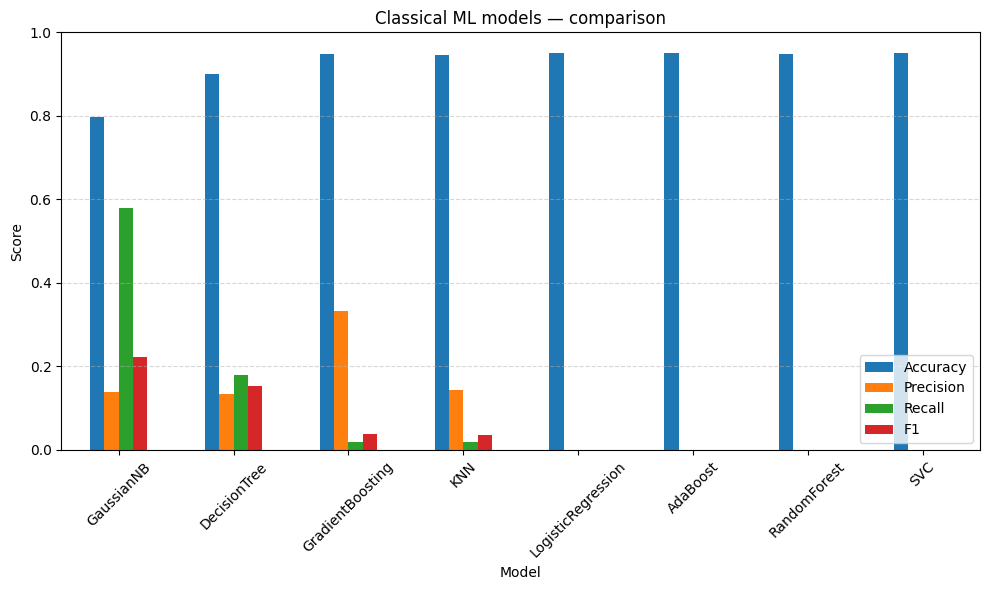

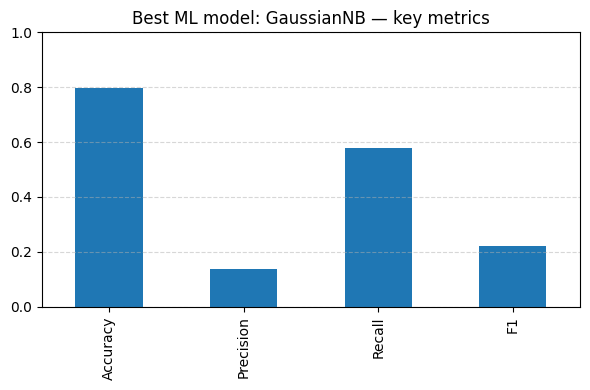


Saved sorted table to: /content/stroke_model_results/ml_results_sorted_by_f1.csv
Saved comparison bar chart to: /content/stroke_model_results/ml_models_comparison_bar.png
Saved best-model chart to: /content/stroke_model_results/best_ml_GaussianNB_metrics.png


In [10]:
# Block A: Best classical ML model (by F1) + comparison table + bar chart
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "/content/stroke_model_results"
ml_csv = os.path.join(OUT_DIR, "ml_results.csv")

if not os.path.exists(ml_csv):
    raise FileNotFoundError(f"{ml_csv} not found. Make sure you ran the training cells and saved results to {OUT_DIR}.")

# Load results
ml_df = pd.read_csv(ml_csv)

# Ensure numeric columns exist and handle NaNs
for col in ["Accuracy","Precision","Recall","F1","ROC-AUC"]:
    if col not in ml_df.columns:
        ml_df[col] = np.nan
ml_df[["Accuracy","Precision","Recall","F1","ROC-AUC"]] = ml_df[["Accuracy","Precision","Recall","F1","ROC-AUC"]].apply(pd.to_numeric, errors='coerce')

# Choose best model by F1, break ties by ROC-AUC
ml_sorted = ml_df.sort_values(by=["F1","ROC-AUC"], ascending=[False, False]).reset_index(drop=True)
best_ml = ml_sorted.iloc[0]

print("=== Classical ML models comparison ===")
display(ml_sorted.style.background_gradient(subset=["F1"], cmap="Greens"))

print("\nBest ML model (selected by highest F1, tie-broken by ROC-AUC):")
print(best_ml.to_dict())

# Save a human-readable CSV of sorted results
ml_sorted.to_csv(os.path.join(OUT_DIR, "ml_results_sorted_by_f1.csv"), index=False)

# Bar chart: show Accuracy, Precision, Recall, F1 for each model (grouped)
metrics = ["Accuracy","Precision","Recall","F1"]
plot_df = ml_sorted.set_index("Model")[metrics]

plt.figure(figsize=(10,6))
plot_df.plot(kind="bar", rot=45, figsize=(10,6))
plt.title("Classical ML models — comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "ml_models_comparison_bar.png"), dpi=150)
plt.show()

# Highlight best model bar(s) by overlaying an outline
# (also save a single-bar view emphasizing best F1)
plt.figure(figsize=(6,4))
best_name = best_ml["Model"]
best_values = plot_df.loc[best_name]
best_values.plot(kind="bar")
plt.title(f"Best ML model: {best_name} — key metrics")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"best_ml_{best_name}_metrics.png"), dpi=150)
plt.show()

print(f"\nSaved sorted table to: {os.path.join(OUT_DIR, 'ml_results_sorted_by_f1.csv')}")
print(f"Saved comparison bar chart to: {os.path.join(OUT_DIR, 'ml_models_comparison_bar.png')}")
print(f"Saved best-model chart to: {os.path.join(OUT_DIR, f'best_ml_{best_name}_metrics.png')}")


=== Deep learning models comparison ===


,Model,Accuracy,F1
0,Keras_MLP_batchnorm,0.948847,0.105263
1,Keras_MLP_small,0.949850,0.000000
2,Keras_MLP_dropout,0.949850,0.000000
3,Keras_MLP_deep,0.949850,0.000000
4,Keras_MLP_shallow,0.949850,0.000000



Best DL model (selected by highest F1, tie-broken by Accuracy):
{'Model': 'Keras_MLP_batchnorm', 'Accuracy': 0.9488465396188566, 'F1': 0.1052631578947368}


<Figure size 800x500 with 0 Axes>

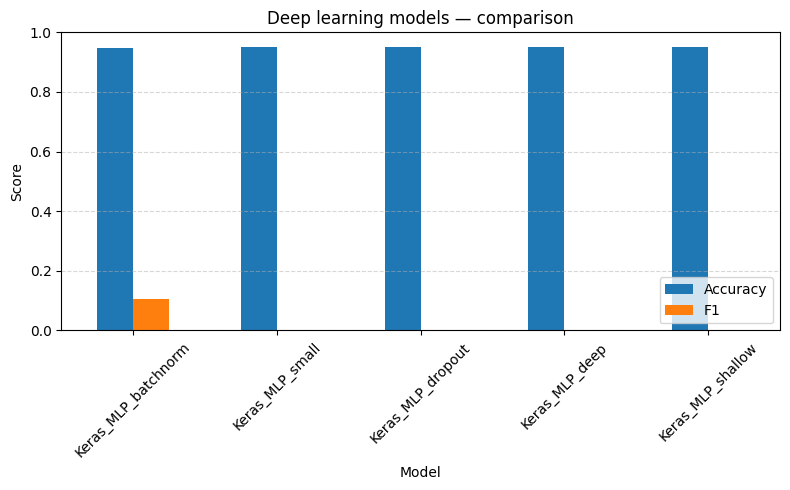

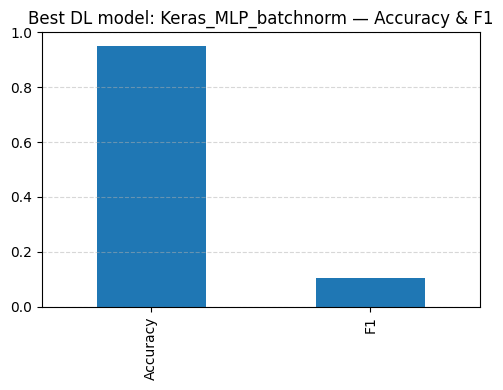


Saved sorted DL table to: /content/stroke_model_results/dl_results_sorted_by_f1.csv
Saved DL comparison bar chart to: /content/stroke_model_results/dl_models_comparison_bar.png
Saved best DL chart to: /content/stroke_model_results/best_dl_Keras_MLP_batchnorm_metrics.png


In [11]:
# Block B: Best deep learning model (by F1) + comparison table + bar chart
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

OUT_DIR = "/content/stroke_model_results"

# try several likely DL results filenames (Keras or sklearn fallback)
dl_candidates = [
    os.path.join(OUT_DIR, "dl_results_keras.csv"),
    os.path.join(OUT_DIR, "dl_results_sklearn_mlp.csv"),
    os.path.join(OUT_DIR, "dl_results.csv"),
    os.path.join(OUT_DIR, "dl_results_sklearn.csv")
]
dl_csv = next((p for p in dl_candidates if os.path.exists(p)), None)
if dl_csv is None:
    raise FileNotFoundError("No DL results CSV found. Looked for: " + ", ".join(dl_candidates))

dl_df = pd.read_csv(dl_csv)

# Ensure numeric columns exist and handle NaNs
for col in ["Accuracy","F1"]:
    if col not in dl_df.columns:
        dl_df[col] = np.nan
dl_df[["Accuracy","F1"]] = dl_df[["Accuracy","F1"]].apply(pd.to_numeric, errors='coerce')

# Choose best DL model by F1 (tie-break by Accuracy)
dl_sorted = dl_df.sort_values(by=["F1","Accuracy"], ascending=[False, False]).reset_index(drop=True)
best_dl = dl_sorted.iloc[0]

print("=== Deep learning models comparison ===")
display(dl_sorted.style.background_gradient(subset=["F1"], cmap="Blues"))

print("\nBest DL model (selected by highest F1, tie-broken by Accuracy):")
print(best_dl.to_dict())

# Save sorted table
dl_sorted.to_csv(os.path.join(OUT_DIR, "dl_results_sorted_by_f1.csv"), index=False)

# Bar chart for DL: show Accuracy and F1 side-by-side
metrics = ["Accuracy","F1"]
plot_df = dl_sorted.set_index("Model")[metrics]

plt.figure(figsize=(8,5))
plot_df.plot(kind="bar", rot=45, figsize=(8,5))
plt.title("Deep learning models — comparison")
plt.ylabel("Score")
plt.ylim(0,1)
plt.legend(loc="lower right")
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "dl_models_comparison_bar.png"), dpi=150)
plt.show()

# Single best-model bar chart
plt.figure(figsize=(5,4))
best_dl_name = best_dl["Model"]
best_dl_vals = plot_df.loc[best_dl_name]
best_dl_vals.plot(kind="bar")
plt.title(f"Best DL model: {best_dl_name} — Accuracy & F1")
plt.ylim(0,1)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, f"best_dl_{best_dl_name}_metrics.png"), dpi=150)
plt.show()

print(f"\nSaved sorted DL table to: {os.path.join(OUT_DIR, 'dl_results_sorted_by_f1.csv')}")
print(f"Saved DL comparison bar chart to: {os.path.join(OUT_DIR, 'dl_models_comparison_bar.png')}")
print(f"Saved best DL chart to: {os.path.join(OUT_DIR, f'best_dl_{best_dl_name}_metrics.png')}")


Best ML model: GaussianNB
Best DL model: Keras_MLP_batchnorm
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


,Model Type,Accuracy,Precision,Recall,F1,ROC-AUC
0,Best ML (GaussianNB),0.797392,0.138095,0.580000,0.223077,0.782851
1,Best DL (Keras_MLP_batchnorm),0.948847,0.428571,0.060000,0.105263,0.759134


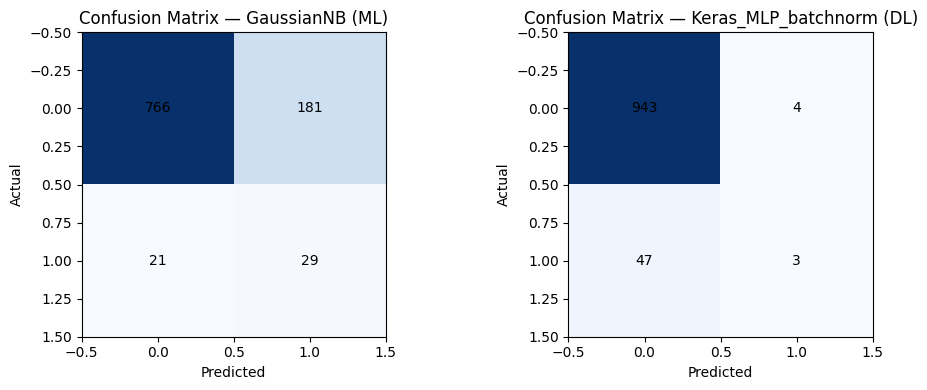

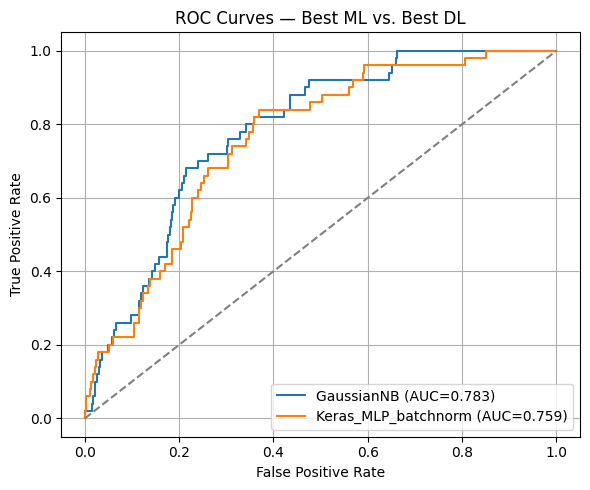


✅ Saved outputs:
- /content/stroke_model_results/best_ml_vs_dl_comparison.csv
- /content/stroke_model_results/best_ml_dl_confusion_matrices.png
- /content/stroke_model_results/best_ml_vs_dl_roc.png


In [13]:
# Block: Compare best ML vs. best DL model — metrics, confusion matrix, ROC curve
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
import joblib

OUT_DIR = "/content/stroke_model_results"

# --- Load ML and DL results ---
ml_path = os.path.join(OUT_DIR, "ml_results_sorted_by_f1.csv")
dl_path = os.path.join(OUT_DIR, "dl_results_sorted_by_f1.csv")

if not os.path.exists(ml_path):
    ml_path = os.path.join(OUT_DIR, "ml_results.csv")
if not os.path.exists(dl_path):
    # fallback for whichever DL file exists
    for p in ["dl_results_keras.csv", "dl_results_sklearn_mlp.csv", "dl_results.csv"]:
        if os.path.exists(os.path.join(OUT_DIR, p)):
            dl_path = os.path.join(OUT_DIR, p)
            break

ml_df = pd.read_csv(ml_path)
dl_df = pd.read_csv(dl_path)

# --- Pick the best by F1 (tie break by ROC-AUC/Accuracy) ---
best_ml = ml_df.sort_values(by=["F1","ROC-AUC"], ascending=[False, False]).iloc[0]
best_dl = dl_df.sort_values(by=["F1","Accuracy"], ascending=[False, False]).iloc[0]

best_ml_name = best_ml["Model"]
best_dl_name = best_dl["Model"]
print(f"Best ML model: {best_ml_name}")
print(f"Best DL model: {best_dl_name}")

# --- Recreate model predictions using trained models already in memory or reload if saved ---
# We assume X_test, y_test, trained_models, dl_models (MLP) etc. are still in memory from previous blocks.
# If not, reload dataset and preprocessing pipeline as before.

try:
    # X_test, y_test, trained_models, dl_models_trained should exist
    pass
except NameError:
    raise ValueError("X_test, y_test, and models are not in memory. Please run the earlier training blocks first.")

# Get predictions and probabilities
ml_model = trained_models[best_ml_name]
y_pred_ml = ml_model.predict(X_test)
if hasattr(ml_model, "predict_proba"):
    y_prob_ml = ml_model.predict_proba(X_test)[:,1]
elif hasattr(ml_model, "decision_function"):
    y_prob_ml = ml_model.decision_function(X_test)
else:
    y_prob_ml = np.zeros_like(y_pred_ml, dtype=float)

# Deep learning model handling
# Try TensorFlow model first; otherwise sklearn MLP fallback
import glob
# FIX: Correct the glob pattern to include .keras extension
keras_models = glob.glob(os.path.join(OUT_DIR, f"{best_dl_name}_keras_model.keras"))
if len(keras_models) > 0:
    from tensorflow.keras.models import load_model
    dl_model = load_model(keras_models[0])
    from sklearn.preprocessing import StandardScaler
    # retrain scaler if not already trained, or use the existing one (scaler_nn)
    # assuming X_train is available globally from previous blocks
    # Check if scaler_nn from Block 4A exists using globals() for broader scope
    if 'scaler_nn' in globals() and globals()['scaler_nn'] is not None:
        scaler_dl_pred = globals()['scaler_nn']
    else:
        print("Warning: scaler_nn not found in globals(). Fitting a new StandardScaler for DL predictions.")
        scaler_dl_pred = StandardScaler().fit(X_train) # Assumes X_train is available

    X_test_scaled = scaler_dl_pred.transform(X_test)
    y_prob_dl = dl_model.predict(X_test_scaled).ravel()
    y_pred_dl = (y_prob_dl >= 0.5).astype(int)
else:
    # fallback to sklearn MLP
    model_file = os.path.join(OUT_DIR, f"{best_dl_name}_sklearn_mlp.pkl")
    if os.path.exists(model_file):
        dl_model = joblib.load(model_file)
        y_pred_dl = dl_model.predict(X_test)
        y_prob_dl = dl_model.predict_proba(X_test)[:,1] if hasattr(dl_model, "predict_proba") else np.zeros_like(y_pred_dl, dtype=float)
    else:
        # Fallback for models not saved to disk and not found by glob.
        # This branch should ideally not be reached if previous saving logic is correct.
        # But if it is, iterating over a copy prevents RuntimeError.
        dl_model = None
        # FIX: Iterate over a copy of locals().items() to avoid RuntimeError
        for name_in_locals, m_in_locals in list(locals().items()):
            if isinstance(m_in_locals, object) and hasattr(m_in_locals, "predict") and best_dl_name in name_in_locals:
                dl_model = m_in_locals
                break
        if dl_model is None:
            raise ValueError(f"Could not find DL model '{best_dl_name}' either saved or in memory.")

        # Ensure y_pred_dl and y_prob_dl are set for the dl_model found in locals()
        # Need to scale X_test for DL models if found in locals()
        if 'scaler_nn' in globals() and globals()['scaler_nn'] is not None: # Check if scaler_nn from Block 4A exists, using globals() for broader scope
            X_test_dl = globals()['scaler_nn'].transform(X_test)
        else:
            # If scaler_nn is not available, try to fit a new one (less ideal, but avoids error)
            print("Warning: scaler_nn not found. Fitting a new StandardScaler for DL predictions.")
            scaler_dl = StandardScaler().fit(X_train) # Assumes X_train is available
            X_test_dl = scaler_dl.transform(X_test)

        y_prob_dl = dl_model.predict(X_test_dl).ravel()
        y_pred_dl = (y_prob_dl >= 0.5).astype(int)

# --- Compute metrics manually for both ---
def metrics_dict(y_true, y_pred, y_prob):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "ROC-AUC": roc_auc_score(y_true, y_prob) if len(np.unique(y_true))==2 else np.nan
    }

ml_metrics = metrics_dict(y_test, y_pred_ml, y_prob_ml)
dl_metrics = metrics_dict(y_test, y_pred_dl, y_prob_dl)

comparison_df = pd.DataFrame([
    {"Model Type": "Best ML ("+best_ml_name+")", **ml_metrics},
    {"Model Type": "Best DL ("+best_dl_name+")", **dl_metrics}
])
display(comparison_df.style.background_gradient(subset=["F1"], cmap="Purples"))
comparison_df.to_csv(os.path.join(OUT_DIR, "best_ml_vs_dl_comparison.csv"), index=False)

# --- Confusion matrices ---
cm_ml = confusion_matrix(y_test, y_pred_ml)
cm_dl = confusion_matrix(y_test, y_pred_dl)

fig, axs = plt.subplots(1,2, figsize=(10,4))
for ax, cm, title in zip(axs, [cm_ml, cm_dl], [f"{best_ml_name} (ML)", f"{best_dl_name} (DL)"]):
    ax.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
    ax.set_title(f"Confusion Matrix — {title}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")
    for (i,j), val in np.ndenumerate(cm):
        ax.text(j,i,int(val), ha='center', va='center')
plt.tight_layout()
plt.savefig(os.path.join(OUT_DIR, "best_ml_dl_confusion_matrices.png"), dpi=150)
plt.show()

# --- ROC curves ---
if len(np.unique(y_test))==2:
    fpr_ml, tpr_ml, _ = roc_curve(y_test, y_prob_ml)
    fpr_dl, tpr_dl, _ = roc_curve(y_test, y_prob_dl)
    auc_ml = auc(fpr_ml, tpr_ml)
    auc_dl = auc(fpr_dl, tpr_dl)
    plt.figure(figsize=(6,5))
    plt.plot(fpr_ml, tpr_ml, label=f"{best_ml_name} (AUC={auc_ml:.3f})")
    plt.plot(fpr_dl, tpr_dl, label=f"{best_dl_name} (AUC={auc_dl:.3f})")
    plt.plot([0,1],[0,1],"--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves — Best ML vs. Best DL")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(OUT_DIR, "best_ml_vs_dl_roc.png"), dpi=150)
    plt.show()
else:
    print("ROC curves skipped (non-binary target).")

print("\n✅ Saved outputs:")
print("-", os.path.join(OUT_DIR, "best_ml_vs_dl_comparison.csv"))
print("-", os.path.join(OUT_DIR, "best_ml_dl_confusion_matrices.png"))
print("-", os.path.join(OUT_DIR, "best_ml_vs_dl_roc.png"))